In [2]:
import numpy as np 
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
import tensorflow

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [11]:
import keras.layers as KL
import keras.models as KM
import keras
from keras.applications.densenet import DenseNet169,DenseNet201

In [5]:
#uncomment if using linux/macos
!rm -rf Train Val
!mkdir Train Val Train/Yes Train/No Val/Yes Val/No

#uncomment if using windows
#!rmdir Train Val /s /q
#!md Train Val Train\Yes Train\No Val\Yes Val\No


img_path = 'project/Dataset/'
train_list = []
val_list = []
for CLASS in os.listdir(img_path):
    if not CLASS.startswith('.'):
        all_files = os.listdir(img_path + CLASS)
        files = [item for item in all_files if "img" in item]
        random.shuffle(files)
        img_num = len(files)
        for (n, file_name) in enumerate(files):
            img = os.path.join(img_path,CLASS,file_name)
            seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
            # 80% of images will be used for training, change the number here 
            # to use different number of images for training your model.
            if n < 0.8*img_num:
                shutil.copy(img, os.path.join('Train/',CLASS,file_name))
                train_list.append(os.path.join('Train/',CLASS,file_name))
                shutil.copy(seg, os.path.join('Train/',CLASS,file_name.split('_')[0]+'_seg.npy'))
            else:
                shutil.copy(img, os.path.join('Val/',CLASS,file_name))
                val_list.append(os.path.join('Val/',CLASS,file_name))
                shutil.copy(seg, os.path.join('Val/',CLASS,file_name.split('_')[0]+'_seg.npy'))

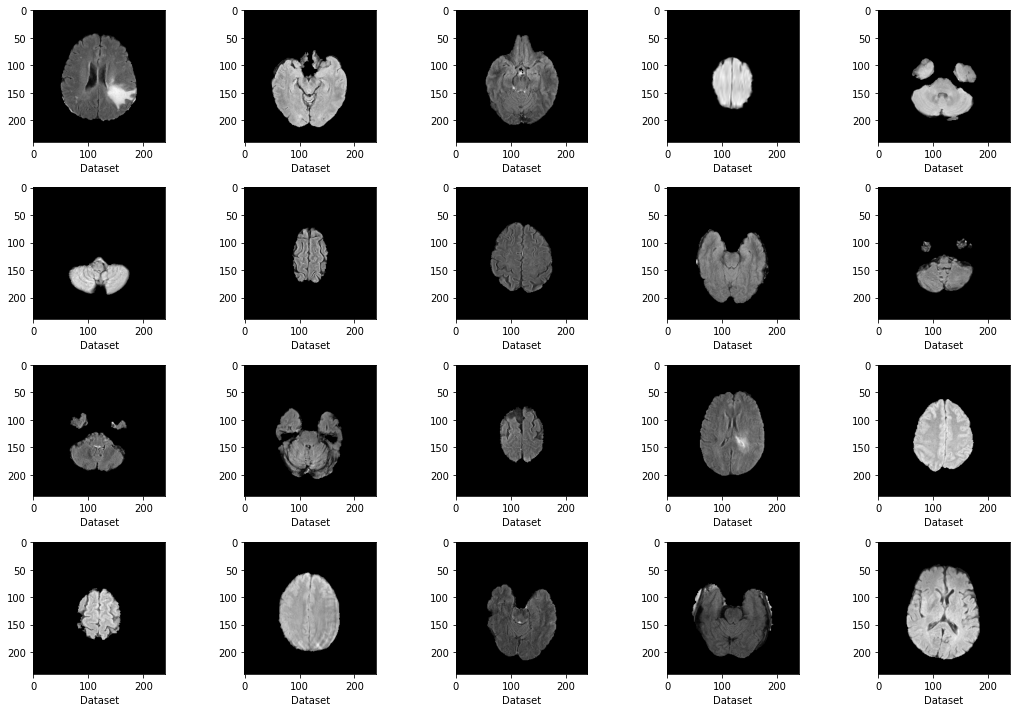

In [6]:
def plot_samples(img_path,n=20):
    files_list = []
    labels_list = []
    for path, subdirs, all_files in os.walk(img_path):
        files = [item for item in all_files if "img" in item]
        for name in files:
            files_list.append(os.path.join(path, name))
            labels_list.append(path.split('/')[1])
    imgs_lbls = list(zip(files_list, labels_list))
    random.shuffle(imgs_lbls)
    files_list, labels_list = zip(*imgs_lbls)
    j = 5
    i = int(n/j)
    plt.figure(figsize=(15,10))
    k = 1
    for file, lbl in zip(files_list[:n], labels_list[:n]):
        img = np.load(file)
        plt.subplot(i,j,k)
        plt.imshow(img[:,:,0], cmap='gray')
        plt.xlabel(lbl)
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_samples(img_path)

In [7]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            X[i,] = np.load(ID)

            # Store class
            y[i] = min(1,np.sum(np.load(ID.split('_')[0]+'_seg.npy')))

        return X, tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [8]:
train_generator = DataGenerator(train_list)
validation_generator = DataGenerator(val_list)
img_size = (240,240)

In [12]:
base_model = DenseNet201(
    #uncomment if you want to train your network from scratch.
    weights = None,
    include_top=False, 
    input_shape=img_size+(3,)
)

In [ ]:
num_classes = 2

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='sigmoid'))

# uncomment here if you want to finetune the top layer(classifier) of a pretrained network only. 
# model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

In [12]:
num_epochs = 50
earlystopping = EarlyStopping(
    monitor='accuracy', 
    mode='max',
    patience=20
)

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[earlystopping]
)

Epoch 1/50
63/63 [==============================] - 28s 439ms/step - loss: 0.5126 - accuracy: 0.8165 - val_loss: 0.4303 - val_accuracy: 0.8250
Epoch 2/50
63/63 [==============================] - 27s 431ms/step - loss: 0.4425 - accuracy: 0.8165 - val_loss: 0.4048 - val_accuracy: 0.8313
Epoch 3/50
63/63 [==============================] - 27s 431ms/step - loss: 0.4105 - accuracy: 0.8185 - val_loss: 0.3690 - val_accuracy: 0.8354
Epoch 4/50
63/63 [==============================] - 27s 431ms/step - loss: 0.3925 - accuracy: 0.8423 - val_loss: 0.4522 - val_accuracy: 0.8000
Epoch 5/50
63/63 [==============================] - 27s 431ms/step - loss: 0.4057 - accuracy: 0.8239 - val_loss: 0.3893 - val_accuracy: 0.8250
Epoch 6/50
63/63 [==============================] - 27s 432ms/step - loss: 0.3837 - accuracy: 0.8338 - val_loss: 0.4069 - val_accuracy: 0.8521
Epoch 7/50
63/63 [==============================] - 27s 432ms/step - loss: 0.3948 - accuracy: 0.8274 - val_loss: 0.3876 - val_accuracy: 0.8375

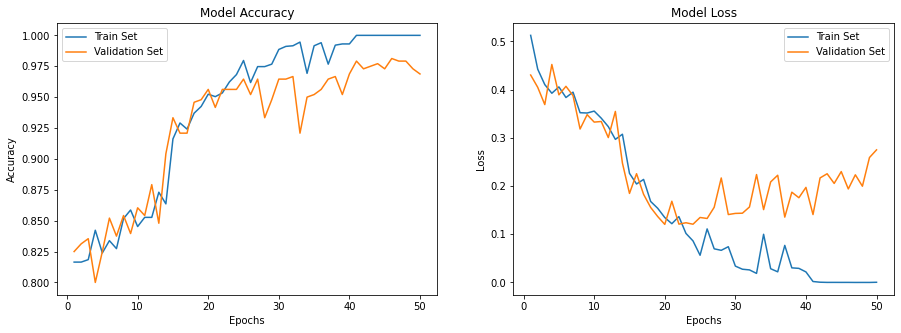

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

In [14]:
model.save('vgg16_dropout0.8.h5')